https://docs.opencv.org/4.x/dc/d0d/tutorial_py_features_harris.html

## Goal

* Harris Corner Detection 이해하기

* CV로 구현하기, Karnia로 구현하기

![nn](data/harris_a.png)
![nn](data/harris_b.png)

## Using OpenCV

In [18]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

img shape:  (612, 612, 3)


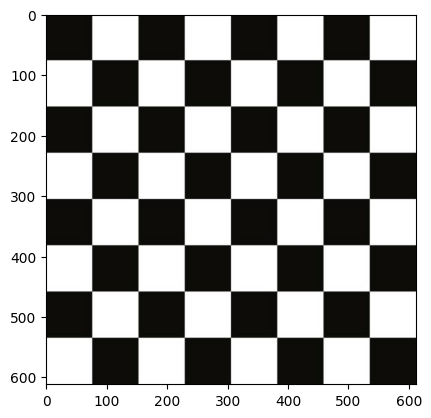

In [19]:
filename = 'data/chessboard.jpg'
img = cv.imread(filename)

gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)

print("img shape: ",img.shape)
plt.imshow(img)
plt.show()

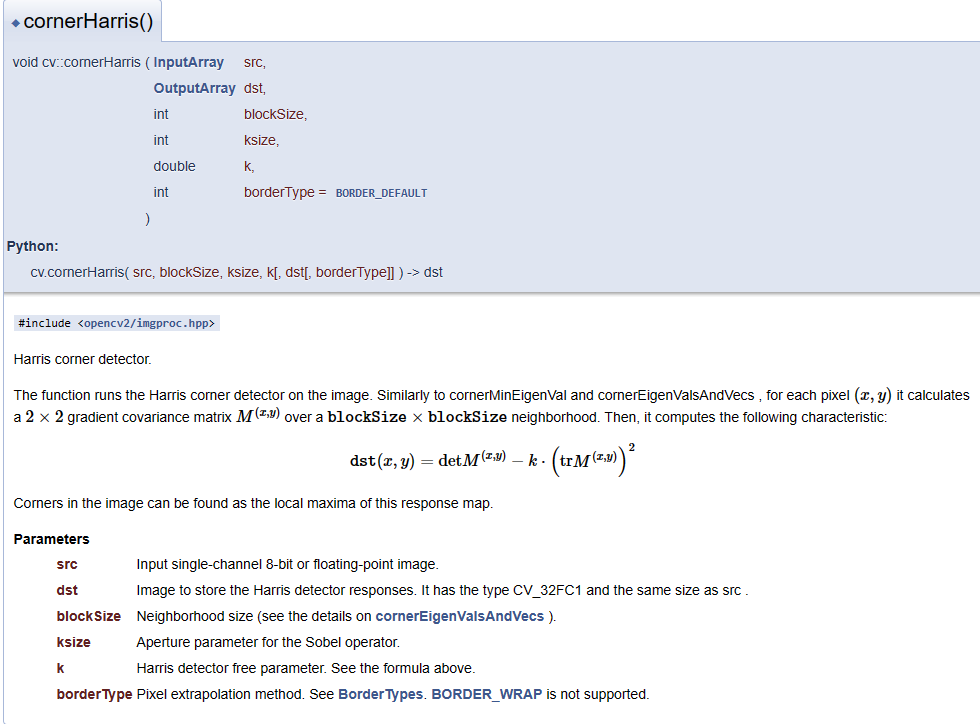

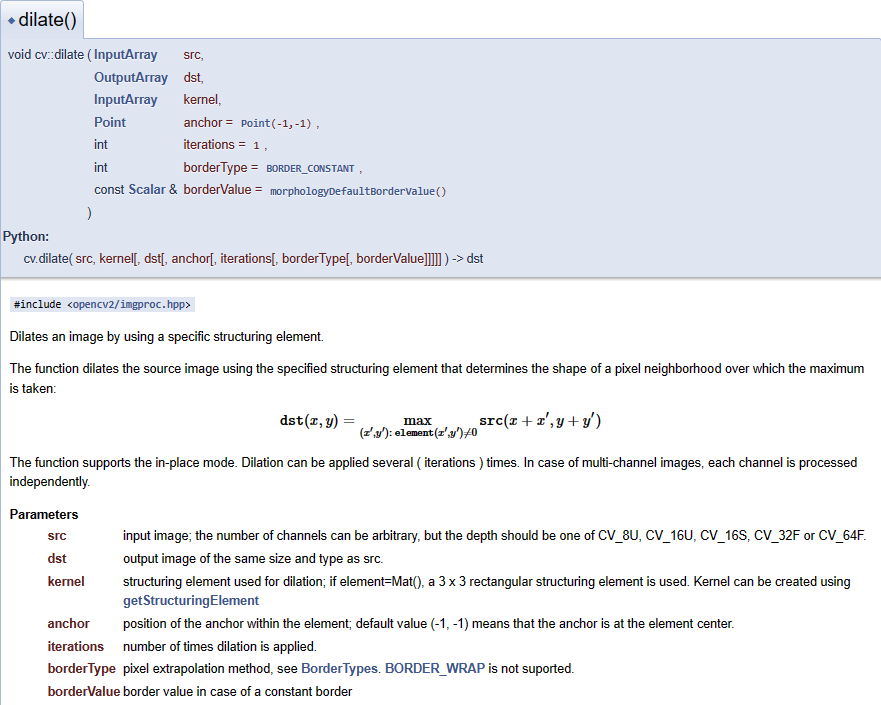

In [14]:
dst = cv.cornerHarris(gray, 2, 3, 0.04)
dst = cv.dilate(dst,None)

(612, 612)

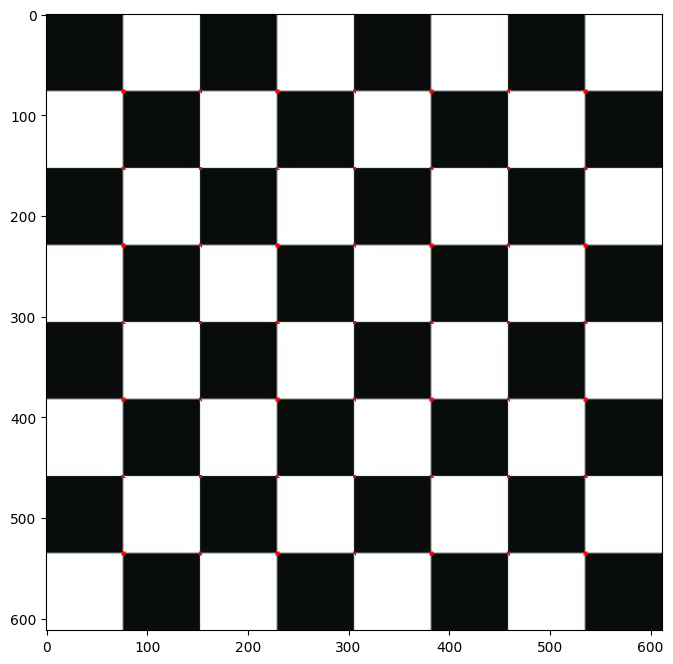

In [16]:
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

plt.figure(figsize=(15,8))
plt.imshow(img[:,:,::-1])
plt.show()

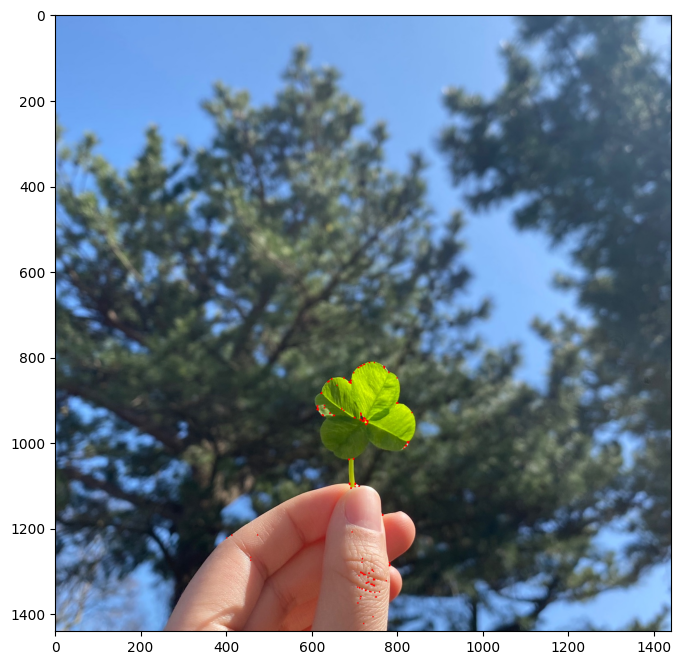

In [17]:
filename = 'data/image.jpeg'
img = cv.imread(filename)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv.cornerHarris(gray, 2, 3, 0.04)

#result is dilated for marking the corners, not important
dst = cv.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

plt.figure(figsize=(15,8))
plt.imshow(img[:,:,::-1])
plt.show()

## Using Kornia library

https://kornia.readthedocs.io/en/latest/_modules/kornia/feature/responses.html

In [40]:
import torch
from torchvision import transforms
import kornia.feature as KF

from PIL import Image

filename = 'data/chessboard.jpg'

In [41]:
np.shape(Image.open(filename))

(612, 612, 3)

In [42]:
np.shape((Image.open(filename).convert('L')))

(612, 612)

In [43]:
transforms.ToTensor()(Image.open(filename).convert('L')).shape

torch.Size([1, 612, 612])

In [38]:
transforms.ToTensor()(Image.open(filename).convert('L')).unsqueeze(0).shape

torch.Size([1, 1, 612, 612])

torch.Size([1, 1, 612, 612])


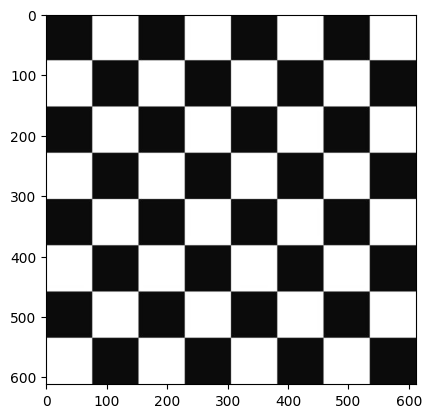

In [45]:
tensor = transforms.ToTensor()(Image.open(filename).convert('L')).unsqueeze(0)
print(tensor.shape)

plt.imshow(tensor.squeeze(), cmap='gray')
plt.show()

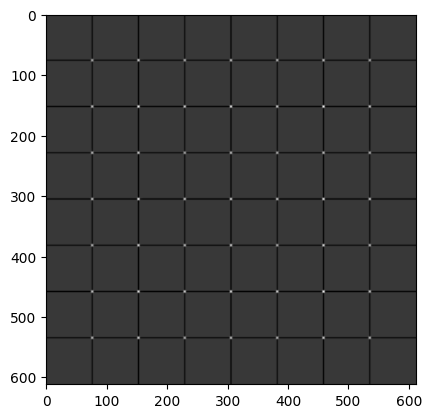

In [46]:
harris = KF.responses.CornerHarris(0.05) 

cornerness = harris(tensor)
plt.imshow(cornerness.squeeze(), cmap='gray')
plt.show()

## (심화) Example on the scale pyramid

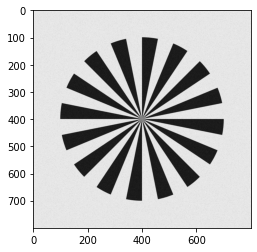

In [10]:
import kornia
import kornia.geometry as KG
from kornia import tensor_to_image as tti

## ScalePyramid create spyramid of blurred and downsamples images
SP = KG.ScalePyramid(3, 1.0, 10)

filename = '../data/siemens.png' # # filename = 'image.jpeg'

img = Image.open(filename)#.convert('L')

timg = kornia.utils.image_to_tensor(np.array(img), keepdim=False).float() / 255.  / 255.  #This specific image somehow has [0, 255**2] range

plt.imshow(kornia.utils.tensor_to_image(timg[0]), 'gray')

7 torch.Size([1, 1, 6, 800, 800])


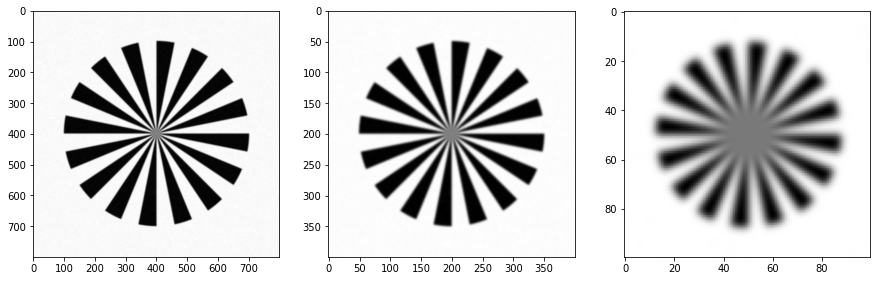

In [11]:
resp = KF.responses.CornerHarris(0.05) 

SP = KG.ScalePyramid(3, 1.6, 10)

pyr, sigmas, scales = SP (timg)
print (len(pyr), pyr[0].shape)

fig, axes = plt.subplots(1,3, figsize=(15,8))

ax = axes[0]
ax.imshow(tti(pyr[0][0,0,0]), 'gray')
ax = axes[1]
ax.imshow(tti(pyr[1][0,0,0]), 'gray')
ax = axes[2]
ax.imshow(tti(pyr[3][0,0,0]), 'gray')
current_level = pyr[1]

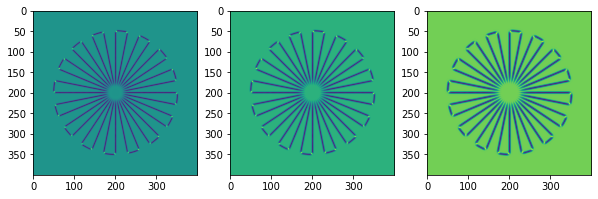

In [12]:

fig, axes = plt.subplots(1,3, figsize=(10,6))

cornerness = resp(current_level[0])
for i in range(3):
    ax = axes[i]
    ax.imshow(tti(cornerness[0,i]))


In [13]:
## The next component is detector of the maximum of the local responce: ConvQuadInterp3d(), 
## which does quadratic interpolation of the location, or ConvSoftArgmax3d, 
## which does softargmax estimation of the location.

nms1 = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), # nms windows size (scale, height, width)
                                       stride=(1,1,1), # stride (scale, height, width)
                                       padding=(1, 1, 1),
                                       temperature=0.1) # nms windows size (scale, height, width)

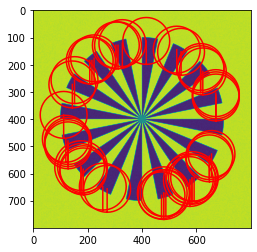

torch.Size([1, 40, 2, 3])


In [18]:
def visualize_LAF(img, LAF, img_idx = 0):
    x, y = kornia.feature.laf.get_laf_pts_to_draw(LAF, img_idx)
    plt.figure()
    plt.imshow(kornia.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'r')
    plt.show()
    return

#Lets detect Harris corners
n_feats = 40
mr_size = 6.0 

harris_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms1,
                                    mr_size=mr_size)

lafs, resps = harris_local_detector(timg)

visualize_LAF(timg, lafs)
print(lafs.shape)

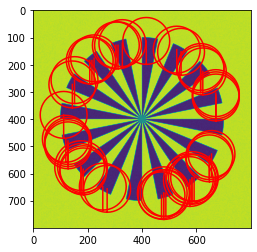

torch.Size([1, 40, 2, 3])


In [19]:
#n_feats = 40
mr_size = 6.0 
nms1 = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), # nms windows size (scale, height, width)
                                       stride=(1,1,1), # stride (scale, height, width)
                                       padding=(1, 1, 1),
                                       temperature=0.1,
                                       strict_maxima_bonus=100.) # nms windows size (scale, height, width)

harris_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms1,
                                    mr_size=mr_size)

lafs, resps = harris_local_detector(timg)
visualize_LAF(timg, lafs)
print(lafs.shape)

생각보다 duplication 제거가 잘 안된다.

따라서, quadrative interpolation 3D 를 통해 subpixel 수준에서의 non-maximal suppression을 한 번 더 수행한다.

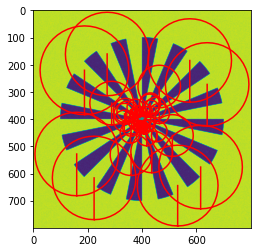

In [20]:
#Lets detect Harris corners w/o duplicates
n_feats = 50
mr_size = 6.0 
nms = kornia.geometry.ConvQuadInterp3d(10, 2e-4) 

harris_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms,
                                    mr_size=mr_size)

lafs, resps = harris_local_detector(timg)
visualize_LAF(timg,lafs)

Harris 가 아니라 다른 affine 모듈 (e.g., DoG 나 LoG를 사용)은 어떻게 될까? 

scale-space detector에 shape estimator를 넣어서 실행.

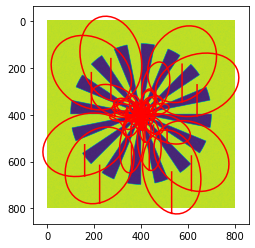

In [21]:
# What about Harris-Affine features?
harris_affine_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=kornia.feature.CornerHarris(0.05),
                                    nms_module=nms,
                                    mr_size=mr_size,
                                    aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),
                                    minima_are_also_good=False)
lafs, resps = harris_affine_local_detector(timg)
visualize_LAF(timg,lafs)

Feature orientation estimator 도 추가 가능

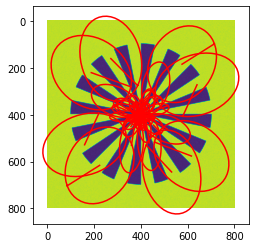

In [22]:
# Now lets also detect feature orientation
harris_affine_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=kornia.feature.CornerHarris(0.05),
                                    nms_module=nms,
                                    mr_size=mr_size,
                                    aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),
                                    ori_module=kornia.feature.LAFOrienter(patch_size=19))

lafs, resps = harris_affine_local_detector(timg)
visualize_LAF(timg,lafs)

## Obtain patch descriptor using the obtained affine regions

In [24]:
#Lets describe patches with SIFT descriptor
descriptor = KF.SIFTDescriptor(32)

patches =  kornia.feature.extract_patches_from_pyramid(timg, lafs)
B, N, CH, H, W = patches.size()
# Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
# So we need to reshape a bit :) 
descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
print (descs.shape)
print (descs[0, 0])

torch.Size([1, 50, 128])
tensor([1.3897e-02, 9.4913e-03, 8.8254e-03, 2.2121e-03, 1.6946e-01, 1.3318e-01,
        5.1314e-02, 9.6590e-03, 2.0085e-01, 2.0085e-01, 4.9988e-02, 1.0167e-01,
        1.8172e-01, 2.0085e-01, 6.9537e-02, 4.4142e-02, 5.5597e-03, 7.1506e-03,
        4.6951e-03, 1.3879e-02, 4.2069e-03, 5.2869e-02, 1.6506e-02, 6.4878e-03,
        1.0546e-02, 1.5283e-01, 6.5669e-02, 1.0444e-01, 1.8078e-02, 1.4658e-01,
        2.0085e-01, 1.2500e-01, 7.0533e-03, 6.6774e-03, 6.5058e-03, 7.7433e-03,
        2.2766e-03, 3.4444e-03, 7.8805e-03, 9.3695e-03, 3.1570e-02, 1.0000e-05,
        9.2600e-03, 1.0437e-02, 2.5858e-02, 6.9899e-03, 4.0632e-02, 1.8392e-02,
        9.4169e-03, 9.3783e-03, 1.1513e-02, 2.6290e-03, 3.4647e-02, 3.1743e-02,
        1.1608e-02, 1.3288e-02, 6.9952e-02, 4.1263e-02, 3.4757e-03, 8.9397e-03,
        1.8036e-01, 4.4292e-02, 5.5341e-03, 2.7432e-03, 7.5267e-03, 1.0208e-02,
        8.5003e-03, 5.1741e-03, 1.4835e-01, 1.2789e-01, 1.2998e-02, 8.5091e-03,
        1.8085e

### Reference 

https://kornia.readthedocs.io/en/latest/feature.html

https://github.com/kornia/kornia-examples/blob/master/local_feature_detection_example.ipynb